In [603]:
import tensorflow as tf
import os
import numpy as np
import cv2 as cv

import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Reshape
import cv2
import numpy as np
from PIL import Image
import math
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
# General
import warnings
warnings.filterwarnings("ignore")
import datetime
from time import time
import pandas as pd
import os
import numpy as np
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

# OpenCV
import cv2

# ScikitLearn for Data Splitting
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold

# Albumentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Pytorch
import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import nms

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
pd.set_option('display.max_colwidth', None)


In [604]:
IMAGE_SIZE = 224
GRID_SIZE = 7
BATCH_SIZE = 16

In [605]:
DATA_PATH = '../data/LISATrafficLightDataset/'

DAY_TRAIN_PATH = '../data/LISATrafficLightDataset/Annotations/Annotations/dayTrain/'


In [606]:
train_day = []
for clipName in tqdm(sorted(os.listdir(DAY_TRAIN_PATH))):
    if 'dayClip' not in clipName:
        continue
    df = pd.read_csv(os.path.join(DAY_TRAIN_PATH,clipName,'frameAnnotationsBOX.csv'),sep=';')
    train_day.append(df)
train_day_df = pd.concat(train_day,axis=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 110.56it/s]


In [607]:
train_day_df

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,Origin track,Origin track frame number
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358,dayTraining/dayClip1/dayClip1Shutter0.000800-Gain-0.mp4,0,dayTraining/dayClip1/dayClip1Shutter0.000800-Gain-0.mp4,0
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411,dayTraining/dayClip1/dayClip1Shutter0.000800-Gain-0.mp4,0,dayTraining/dayClip1/dayClip1Shutter0.000800-Gain-0.mp4,0
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357,dayTraining/dayClip1/dayClip1Shutter0.000800-Gain-0.mp4,1,dayTraining/dayClip1/dayClip1Shutter0.000800-Gain-0.mp4,1
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410,dayTraining/dayClip1/dayClip1Shutter0.000800-Gain-0.mp4,1,dayTraining/dayClip1/dayClip1Shutter0.000800-Gain-0.mp4,1
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356,dayTraining/dayClip1/dayClip1Shutter0.000800-Gain-0.mp4,2,dayTraining/dayClip1/dayClip1Shutter0.000800-Gain-0.mp4,2
...,...,...,...,...,...,...,...,...,...,...
1935,dayTraining/dayClip9--00950.jpg,goLeft,971,174,1067,314,dayTraining/dayClip9/dayClip9Shutter0.000200-Gain-0.mp4,950,dayTraining/dayClip9/dayClip9Shutter0.000200-Gain-0.mp4,950
1936,dayTraining/dayClip9--00951.jpg,goLeft,1021,171,1099,306,dayTraining/dayClip9/dayClip9Shutter0.000200-Gain-0.mp4,951,dayTraining/dayClip9/dayClip9Shutter0.000200-Gain-0.mp4,951
1937,dayTraining/dayClip9--00953.jpg,warningLeft,1115,182,1199,299,dayTraining/dayClip9/dayClip9Shutter0.000200-Gain-0.mp4,953,dayTraining/dayClip9/dayClip9Shutter0.000200-Gain-0.mp4,953
1938,dayTraining/dayClip9--00954.jpg,warningLeft,1155,186,1260,294,dayTraining/dayClip9/dayClip9Shutter0.000200-Gain-0.mp4,954,dayTraining/dayClip9/dayClip9Shutter0.000200-Gain-0.mp4,954


In [608]:
df = train_day_df


In [609]:
def changeFilename(x):
    filename = x.Filename
    
    splitted = filename.split('/')
    clipName = splitted[-1].split('--')[0]
    return os.path.join(DATA_PATH,f'dayTrain/dayTrain/{clipName}/frames/{splitted[-1]}')

df['Filename'] = df.apply(changeFilename,axis=1)

In [610]:
df = df.drop(['Origin file','Origin track','Origin track frame number','Origin frame number','Annotation tag'],axis=1)

In [611]:
df.columns = ['filename','x_min','y_min','x_max','y_max']
df['label'] = 1


In [612]:
df

,filename,x_min,y_min,x_max,y_max,label
0,../data/LISATrafficLightDataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00000.jpg,698,333,710,358,1
1,../data/LISATrafficLightDataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00000.jpg,846,391,858,411,1
2,../data/LISATrafficLightDataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00001.jpg,698,337,710,357,1
3,../data/LISATrafficLightDataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00001.jpg,847,390,859,410,1
4,../data/LISATrafficLightDataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00002.jpg,698,331,710,356,1
...,...,...,...,...,...,...
1935,../data/LISATrafficLightDataset/dayTrain/dayTrain/dayClip9/frames/dayClip9--00950.jpg,971,174,1067,314,1
1936,../data/LISATrafficLightDataset/dayTrain/dayTrain/dayClip9/frames/dayClip9--00951.jpg,1021,171,1099,306,1
1937,../data/LISATrafficLightDataset/dayTrain/dayTrain/dayClip9/frames/dayClip9--00953.jpg,1115,182,1199,299,1
1938,../data/LISATrafficLightDataset/dayTrain/dayTrain/dayClip9/frames/dayClip9--00954.jpg,1155,186,1260,294,1


In [613]:
bb_box = (df[['x_min','y_min','x_max','y_max','label']].values)

In [614]:
images = (df[['filename']].values)

In [615]:
images_list = []
for image in images:
    images_list.append(image[0])
images = images_list


In [689]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, bb_box, test_size=0.15, random_state=42)

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)



# X_train = X_train.tolist()
# X_val = X_val.tolist()
# y_train = y_train.tolist()
# y_val = y_val.tolist()

In [693]:
y_train

array([[1096,  213, 1138,  288,    1],
       [ 296,  296,  311,  314,    1],
       [ 759,   80,  804,  150,    1],
       ...,
       [ 412,  123,  478,  238,    1],
       [1096,  213, 1138,  288,    1],
       [ 470,  286,  485,  304,    1]], dtype=int64)

In [617]:
print(len(y_test),len(X_test))
print(len(X_train),len(y_train))


5672 5672
27317 27317


In [618]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, shuffle=False):
        self.images = images
        self.labels = labels
        self.shuffle = shuffle
    
    def __len__(self):
        return (np.ceil(len(self.images) / int(BATCH_SIZE))).astype(int)
    
    def __getitem__(self, idx):
        batch_x = self.images[idx * BATCH_SIZE : (idx + 1) * BATCH_SIZE] # images path
        batch_y = self.labels[idx * BATCH_SIZE : (idx + 1) * BATCH_SIZE] # raw label

        train_image, train_label = [], []
        for i in range(0, len(batch_x)):
            img_path, label = batch_x[i], batch_y[i]
            image, label_matrix = self.read(img_path, label) #actual image array (IMAGE_SIZE, IMAGE_SIZE, 3) (GRID_SIZE, GRID_SIZE, 5 * BOX_SIZE + CLASS) 
            train_image.append(image)
            train_label.append(label_matrix)
        
        if self.shuffle:
            indices = tf.range(start=0, limit=tf.shape(train_image)[0], dtype=tf.int32)
            idx = tf.random.shuffle(indices)
            train_image = tf.gather(train_image, idx)
            train_label = tf.gather(train_label, idx)

        return np.array(train_image, dtype=np.float32), np.array(train_label, dtype=np.float32)
    
    def read(self, img_path, label):
        image = cv.imread(img_path)
        h, w = image.shape[0:2]
        image = cv.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        image = image / 255.

#         label_matrix = np.zeros([GRID_SIZE, GRID_SIZE, 5 * BOX_SIZE + NUM_CLASS])
        label_matrix = np.zeros([GRID_SIZE, GRID_SIZE, 5])

#         for l in label:
#         l = l.split(',')
#         l = np.array(l, dtype=int)

        xmin, ymin, xmax, ymax = label[0] / w, label[1] / h, label[2] / w, label[3] / h # [0, 1]

        x, y = (xmin + xmax) / 2, (ymin + ymax) / 2
        w, h = xmax - xmin, ymax - ymin

        #convert x, y relative to the cell
        i, j = int(GRID_SIZE * y), int(GRID_SIZE * x)
        x = GRID_SIZE * x - j # 7 * [0,1] = [0, 7] e.g: 6.43 - int(6.43) = 0.43 => relative to the cell
        y = GRID_SIZE * y - i
        label_matrix[i, j] = [x, y, w, h, 1]
#             if l[4] == 0:
#                 label_matrix[i, j] = [x, y, w, h, 1, 1, 0]
#             if l[4] == 1:
#                 label_matrix[i, j] = [x, y, w, h, 1, 0, 1]
        return image, label_matrix


In [619]:
trainingDataGenerator = DataGenerator(X_train, y_train)
validationDataGenerator = DataGenerator(X_val, y_val)
testDataGenerator = DataGenerator(X_test, y_test)


In [679]:
def TestPrint(image, label):
    fig, ax = plt.subplots()
    ax.set_axis_off()

    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if label[i][j][4] > 0.2:
                print(label[i][j])
                x, y, w, h = label[i][j][:4]

                xmax = int(((x + j) / GRID_SIZE * IMAGE_SIZE) + (w * IMAGE_SIZE) / 2)
                xmin = int(((x + j) / GRID_SIZE * IMAGE_SIZE) - (w * IMAGE_SIZE) / 2)
                ymax = int(((y + i) / GRID_SIZE * IMAGE_SIZE) + (h * IMAGE_SIZE) / 2)
                ymin = int(((y + i) / GRID_SIZE * IMAGE_SIZE) - (h * IMAGE_SIZE) / 2)

#                 className = classArray[tf.argmax(label[i][j][5:], axis=-1)]
#                 cv.putText(image, className, (xmin, ymax + 10), cv.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 255, 255))
                cv.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 0, 255), 1)

    ax.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.show()

In [622]:
print(x_train_sample[idx].shape)
type(x_train_sample[idx])

(224, 224, 3)


numpy.ndarray

In [623]:
print(x_train_sample[idx].shape)
type(y_train__sample[idx])

(224, 224, 3)


numpy.ndarray

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.15976563 0.3015625  0.03984375 0.08854166 1.        ]


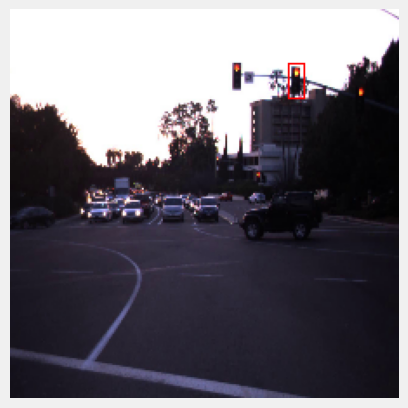

In [663]:
x_train_sample,y_train__sample = trainingDataGenerator.__getitem__(1000)
idx = 3
TestPrint(x_train_sample[idx], y_train__sample[idx])

In [625]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Reshape
import cv2
import numpy as np

# Load EfficientNetB0 model
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=x_train[0].shape)

for layer in base_model.layers:
    layer.trainable = False

# Add two more convolutional layers
x = base_model.output
x = Conv2D(filters=512, kernel_size=1, strides=(1, 1), activation='relu' padding='same')(x)
x = Conv2D(filters=5, kernel_size=1, strides=(1, 1), activation='linear' activation='linear', padding='same')(x)
# x = Reshape(target_shape=(7, 7, 5))(x)

# Create a new model with modified output shape
model = tf.keras.models.Model(inputs=base_model.input, outputs=x)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_18 (Rescaling)       (None, 224, 224, 3)  0           ['input_10[0][0]']               
                                                                                                  
 normalization_9 (Normalization  (None, 224, 224, 3)  7          ['rescaling_18[0][0]']           
 )                                                                                                
                                                                                            

                                                                                                  
 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_b

 block4b_dwconv (DepthwiseConv2  (None, 14, 14, 480)  4320       ['block4b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePoolin

                                                                                                  
 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
          

                                                                                                  
 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
          

                                                                                                  
 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation) 

In [626]:
#YOLO LOSS !!!
def yoloLoss(y_true, y_pred):
    coordLoss = CoordLoss(y_true, y_pred)
    confidenceLoss = ConfidenceLoss(y_true, y_pred)
#     classLoss = ClassLoss(y_true, y_pred)

    return 100*coordLoss + confidenceLoss #+ 5 * classLoss

def CoordLoss(y_true, y_pred):
    #find if it exist an object in the grid
    existsObject = tf.expand_dims(y_true[..., 4], -1)

    xy_pred = existsObject * y_pred[..., 0:2]
    xy_true = existsObject * y_true[..., 0:2]

    wh_pred = existsObject * tf.sqrt(y_pred[..., 2:4])
    wh_true = existsObject * tf.sqrt(y_true[..., 2:4])

    coordLoss = tf.reduce_sum(tf.math.square(wh_pred - wh_true))
    coordLoss += tf.reduce_sum(tf.math.square(xy_pred - xy_true))

    return coordLoss / tf.cast(tf.math.count_nonzero(existsObject), dtype=tf.float32) #mean square error

def ConfidenceLoss(y_true, y_pred):
    existsObject = tf.expand_dims(y_true[..., 4], -1)

    confidenceLoss = tf.reduce_sum(tf.math.square(existsObject * (y_true[..., 4:5] - y_pred[..., 4:5])))
    confidenceLoss += 0.5*tf.reduce_sum(tf.math.square((1 - existsObject) * (y_true[..., 4:5] - y_pred[..., 4:5])))

    return confidenceLoss / tf.cast(tf.math.count_nonzero(existsObject), dtype=tf.float32) #mean, but it's fine if we don't

# def ClassLoss(y_true, y_pred):
#     existsObject = tf.expand_dims(y_true[..., 4], -1)

#     classLoss = tf.reduce_sum(tf.math.square(existsObject * (y_true[..., 5:] - y_pred[..., 5:])))
#     return classLoss / tf.cast(tf.math.count_nonzero(existsObject), dtype=tf.float32) #mean, but it's fine if we don't

In [627]:
model.compile(loss = yoloLoss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[CoordLoss, ConfidenceLoss,"accuracy"]) 


In [628]:
model.fit(  x = trainingDataGenerator,
            validation_data = (validationDataGenerator),
            epochs = 2,
            validation_freq = 3
            )

Epoch 1/2
1708/1708 [==============================] - 796s 463ms/step - loss: 15.1379 - CoordLoss: 0.1410 - ConfidenceLoss: 1.0311 - accuracy: 0.3840
Epoch 2/2
1708/1708 [==============================] - 808s 473ms/step - loss: 11.8369 - CoordLoss: 0.1098 - ConfidenceLoss: 0.8530 - accuracy: 0.3838


In [388]:
accuracy = model.evaluate(testDataGenerator)

# Print the model's accuracy on the validation or test set
print('Accuracy:', accuracy[3])

75/75 [==============================] - 37s 474ms/step - loss: 10.7957 - CoordLoss: 0.0397 - ConfidenceLoss: 0.8737 - accuracy: 0.2653
Accuracy: 0.2652890682220459


In [700]:
type(image)

numpy.ndarray

In [699]:
image.shape

(224, 224, 3)

1/1 [==============================] - 0s 81ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.30932182 0.4809947  0.02934084 0.07015247 0.21666172]
[0.30100262 0.48312697 0.02838942 0.06865326 0.29588503]
[0.219964   0.52659214 0.0274006  0.07501891 0.39555725]
[0.19100101 0.709778   0.02926849 0.08203711 0.24807282]


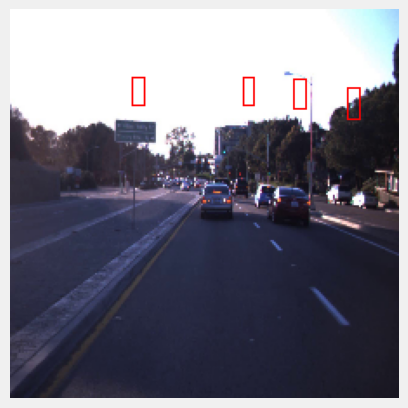

1/1 [==============================] - 0s 81ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.30911168 0.48101318 0.02932804 0.07014158 0.21693613]
[0.30047956 0.4829904  0.02840682 0.06870957 0.29662246]
[0.21959023 0.5265733  0.02741305 0.07505815 0.39611024]
[0.19053239 0.70946294 0.02917585 0.08184793 0.24995297]


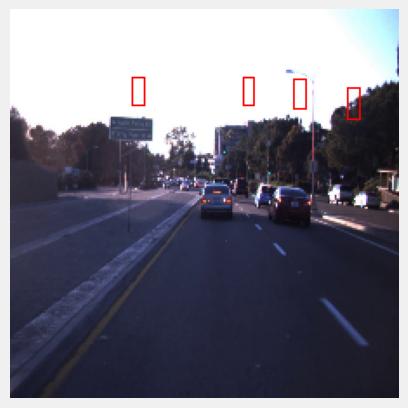

1/1 [==============================] - 0s 85ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.30895036 0.48091653 0.02934705 0.07019626 0.21747889]
[0.30060145 0.4828845  0.02840485 0.06870672 0.29630727]
[0.21984261 0.5262941  0.0274277  0.07508124 0.3955192 ]
[0.190897   0.70882785 0.02920615 0.08190271 0.2492312 ]


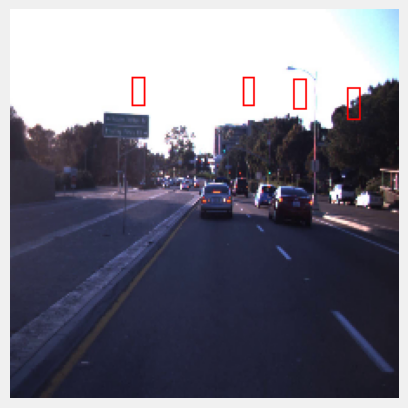

1/1 [==============================] - 0s 88ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.30911356 0.48067036 0.02936665 0.07023767 0.21693659]
[0.3010957  0.482622   0.02840266 0.06868362 0.29524246]
[0.22068454 0.5260636  0.02739419 0.07494321 0.39300853]
[0.19191846 0.70839876 0.02917758 0.08170775 0.24750994]


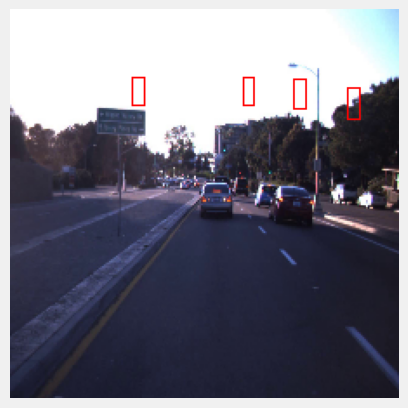

1/1 [==============================] - 0s 79ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.30906412 0.48053163 0.02938879 0.07028574 0.21714106]
[0.30082414 0.48263767 0.02841402 0.0687233  0.2955061 ]
[0.22031833 0.52615494 0.02742102 0.07503151 0.39385846]
[0.19178616 0.7086389  0.02918811 0.08174872 0.24791816]


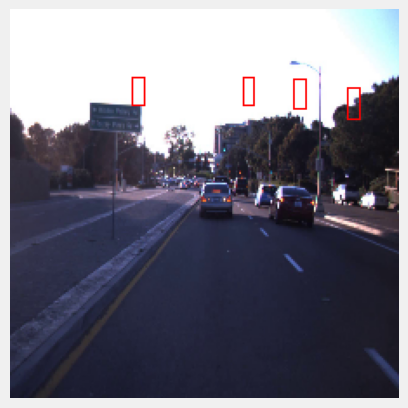

1/1 [==============================] - 0s 78ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.30877087 0.48031965 0.02942773 0.07038119 0.21774201]
[0.30067164 0.4827174  0.02841611 0.06873567 0.2957523 ]
[0.22004242 0.52623975 0.02742824 0.07506936 0.39505097]
[0.19167845 0.7085296  0.02918855 0.0817866  0.2484888 ]


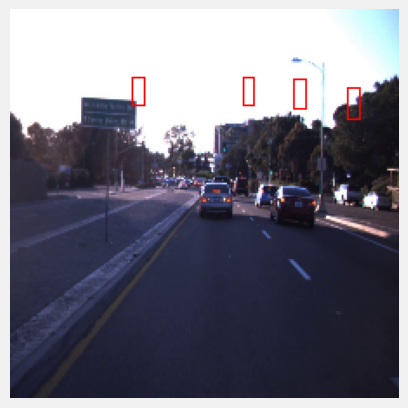

1/1 [==============================] - 0s 93ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.3087513  0.4800173  0.02948671 0.07049926 0.21778235]
[0.30093694 0.48228556 0.02844951 0.06880127 0.2952463 ]
[0.22035095 0.5256203  0.02747672 0.07518467 0.39452845]
[0.19212964 0.70816934 0.0292555  0.0818823  0.24895102]


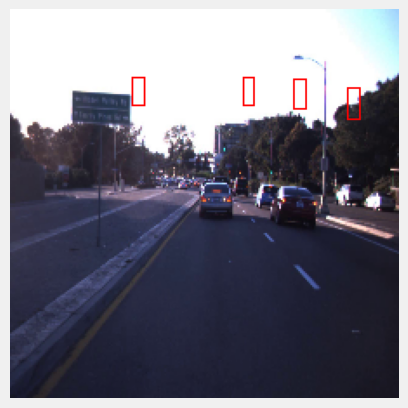

1/1 [==============================] - 0s 88ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.3087264  0.47974357 0.02950479 0.07055032 0.21744823]
[0.30118304 0.48261872 0.02841804 0.06872708 0.29406238]
[0.22042543 0.5262637  0.02742061 0.07503939 0.39370704]
[0.19196334 0.70833147 0.02914961 0.08168852 0.2491318 ]


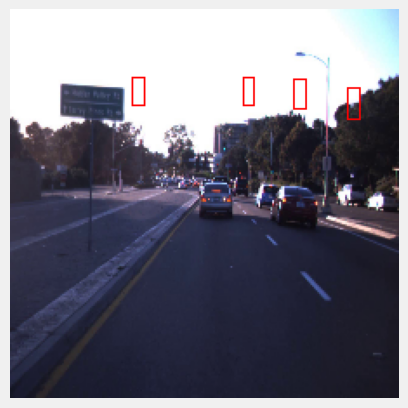

1/1 [==============================] - 0s 87ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.30833897 0.47921258 0.02957402 0.07073592 0.21673317]
[0.30168748 0.48248821 0.02841827 0.06871876 0.29255533]
[0.22086103 0.52601504 0.02742198 0.07502715 0.39226982]
[0.19255131 0.7077559  0.02913157 0.08160615 0.24865398]


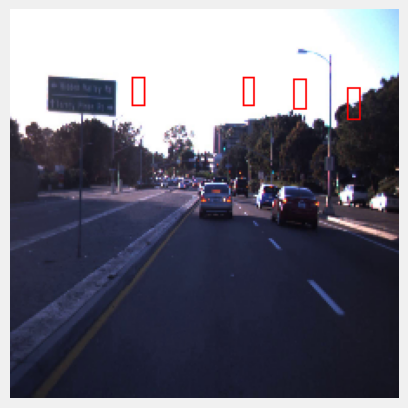

In [702]:
for i in range(9):
    image = cv.imread('../data/LISATrafficLightDataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--0000' + str(i) + '.jpg')
    image = cv.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
#     image = image / 255
    image = (image / 255).astype(np.float32)

    TestPrint(image, model.predict(np.expand_dims(image, 0))[0])

In [687]:
def TestPrint_1(image, label):
    fig, ax = plt.subplots()
    ax.set_axis_off()

    boxes = []
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if label[i][j][4] > 0.2:
                x, y, w, h = label[i][j][:4]
                xmax = int(((x + j) / GRID_SIZE * IMAGE_SIZE) + (w * IMAGE_SIZE) / 2)
                xmin = int(((x + j) / GRID_SIZE * IMAGE_SIZE) - (w * IMAGE_SIZE) / 2)
                ymax = int(((y + i) / GRID_SIZE * IMAGE_SIZE) + (h * IMAGE_SIZE) / 2)
                ymin = int(((y + i) / GRID_SIZE * IMAGE_SIZE) - (h * IMAGE_SIZE) / 2)
                confidence = label[i][j][4]
                boxes.append([xmin, ymin, xmax, ymax, confidence])

    # apply non-maximum suppression
    nms_boxes = []
    while len(boxes) > 0:
        max_conf_idx = np.argmax(np.array(boxes)[:, 4])
        box = boxes[max_conf_idx]
        nms_boxes.append(box)
        boxes.pop(max_conf_idx)
        for b in boxes:
            if iou(box, b) > 0.2:
                boxes.remove(b)

    # draw boxes after nms
    for box in nms_boxes:
        xmin, ymin, xmax, ymax, confidence = box
#         cv.putText(image, (xmin, ymax + 10), cv.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 255, 255))
        cv.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 0, 255), 1)

    ax.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.show()

def iou(box1, box2):
    # box1: [xmin, ymin, xmax, ymax]
    # box2: [xmin, ymin, xmax, ymax]
    x1, y1, x2, y2 = box1[:4]
    x3, y3, x4, y4 = box2[:4]
    xi1 = max(x1, x3)
    yi1 = max(y1, y3)
    xi2 = min(x2, x4)
    yi2 = min(y2, y4)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x4 - x3) * (y4 - y3)
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

1/1 [==============================] - 0s 79ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


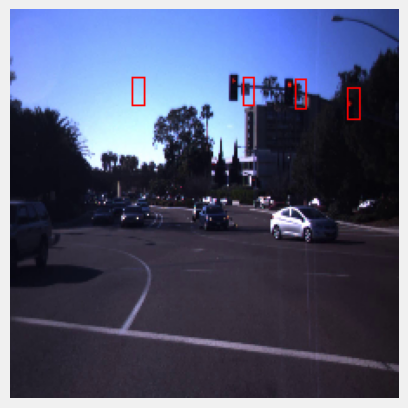

In [703]:
x_train, y_train = trainingDataGenerator.__getitem__(1)
idx = 0
# for i in range(9):
#     image = cv.imread('images/Cats_Test20' + str(i) + '.png')
#     image = cv.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
#     image = image / 255.
TestPrint_1(x_train[idx], model.predict(np.expand_dims(x_train[idx], 0))[0])
    


In [532]:
model.predict(np.expand_dims(x_train_sample[idx], 0))[0][5][5]

1/1 [==============================] - 0s 75ms/step


array([0.5368371 , 0.658729  , 0.01651269, 0.03896123, 0.04961259],
      dtype=float32)